<a href="https://colab.research.google.com/github/Kaiser-14/text-analysis/blob/master/text_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analysis Files: HAMLET

## Summary

In this practice you will learn how to work with text in order to manipulate words as numbers to put the data in the correct way to work with machine/deep learning techniques. You will learn how to process big files of text (books) in order to clean the text, remove strange characters and punctuations and convert all the words in a suitable form to use bag of words or word2vec techniques. Finally you will use more complex techniques as page rank to known the most relevance sentences in a text and you will perform a cluster analysis over words.

As part of your final work, one book have been proposed (Hamlet.txt). The main idea is clean the text and analyse the text using the techniques proposed in the subject. To be, or not to be, that is the question...


## Practice

### Importing files

It is neccessary to import previously all the packages used in this practice. They will help to clean the text and process it to show some graphics.

In this practice, I will work with Hamlet book, provided in a .txt file. Printing the text I find that there are many things to preprocess, apart from stopwords and punctuations, also I have to remove the first 8 characters of each line.

In [ ]:
#!pip install unidecode
#!pip install num2words
import unidecode as unidecode
import matplotlib.pyplot as plt
import re

from num2words import num2words
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec

hamlet = open('Hamlet.txt', encoding="utf8").read().split('\n')
print(hamlet)

['     1  \ufeffProject Gutenberg Etext of Hamlet by Shakespeare', "     2  PG has multiple editions of William Shakespeare's Complete Works", '     3  ', '     4  ', '     5  Copyright laws are changing all over the world, be sure to check', '     6  the copyright laws for your country before posting these files!!', '     7  ', '     8  Please take a look at the important information in this header.', '     9  We encourage you to keep this file on your own disk, keeping an', '    10  electronic path open for the next readers.  Do not remove this.', '    11  ', '    12  ', '    13  **Welcome To The World of Free Plain Vanilla Electronic Texts**', '    14  ', '    15  **Etexts Readable By Both Humans and By Computers, Since 1971**', '    16  ', '    17  *These Etexts Prepared By Hundreds of Volunteers and Donations*', '    18  ', '    19  Information on contacting Project Gutenberg to get Etexts, and', '    20  further information is included below.  We need your donations.', '    21  '

### Preprocessing

As I have just mentioned in the previous block, it is needed to preprocess the text to start working with it. Looking at the raw file, I checked that there are several lines that do not include the story itself, and they are based on information about the book (characters, copyright, etc.). So, first step, remove unnecessary lines.

Also needed to clarify the contractions included in the book, which are included before the dialogue line for each character.

In [ ]:
hamlet = hamlet[332:7059]
print(hamlet)

characters_contractions_mapping = {
    "King": "King", "Ham": "Hamlet", "Pol": "Polonius", "Hor": "Horatio", "Laer": "Laertes", "Volt": "Voltimand",
    "Cor": "Cornelius", "Ros": "Rosencrantz", "Guil": "Guildenstern", "Osr": "Osric", "Gent": "Gentleman",
    "Mar": "Marcellus", "Ber": "Bernardo", "Fran": "Francisco", "Rey": "Reynaldo", "Clown": "Clowns",
    "Fort": "Fortinbras", "Capt": "Captain", "Ghost": "Ghost", "Queen": "Queen", "Oph": "Ophelia"}

['   333  ACT I.', '   334  ', '   335  Scene I. Elsinore. A platform before the Castle.', '   336  ', '   337  [Francisco at his post. Enter to him Bernardo.]', '   338  ', '   339  Ber.', "   340  Who's there?", '   341  ', '   342  Fran.', '   343  Nay, answer me: stand, and unfold yourself.', '   344  ', '   345  Ber.', '   346  Long live the king!', '   347  ', '   348  Fran.', '   349  Bernardo?', '   350  ', '   351  Ber.', '   352  He.', '   353  ', '   354  Fran.', '   355  You come most carefully upon your hour.', '   356  ', '   357  Ber.', "   358  'Tis now struck twelve. Get thee to bed, Francisco.", '   359  ', '   360  Fran.', "   361  For this relief much thanks: 'tis bitter cold,", '   362  And I am sick at heart.', '   363  ', '   364  Ber.', '   365  Have you had quiet guard?', '   366  ', '   367  Fran.', '   368  Not a mouse stirring.', '   369  ', '   370  Ber.', '   371  Well, good night.', '   372  If you do meet Horatio and Marcellus,', '   373  The rivals of m

Before each dialogue, there is a contraction containing the name of the character, so I need to define a function to expand all of them.

In [ ]:
contractions_re = re.compile('(%s)' % '|'.join(characters_contractions_mapping.keys()))
def expand_contractions(s, characters_contractions_mapping=characters_contractions_mapping):
    def replace(match):
        return characters_contractions_mapping[match.group(0)]
    return contractions_re.sub(replace, s)

Now I have only the story, starting with Act I but I need to continue with the preprocessing, so in one loop, I take care of all the things that need to be removed:


1.   Remove first 8 characters in each line. Before cleaning, they include blank spaces, and line number.
2.   The text include some blank lines, not useful for the analysis.
3.   Tokenize the text.
4.   Expand contraction characters as mentioned before
5.   Remove punctuation, accents, blaks, convert to lower case and replace numbers by words.
6.   Due to this preprocessing, it is possible that some lines will be completely removed, because they are not useful, or they are based on stopwords or similar, so I need to remove also this lines to have a clear list.
7.   Finally, lemmatize the words.



In [ ]:
# In order to preprocess all the data, I try to do it in only one loop
# Create tokens for each sentence
hamlet_processed = list()
porter = PorterStemmer()
lem = WordNetLemmatizer()

for sentence in hamlet:
    # Remove extra numeration columns in the text
    sentence = sentence[8:]
    # Remove empty lines
    if sentence == "": continue
    # Tokenize Hamlet
    tokens = word_tokenize(sentence)
    # Expand contractions characters
    tokens.append(expand_contractions(str(tokens)))
    # Remove punctuation
    tokens = [re.sub(r'[^a-zA-Z0-9]', r' ', token) for token in tokens]
    # Remove accents
    tokens = [unidecode.unidecode(token) for token in tokens]
    # Remove blanks, convert to lower case and replace numbers by words
    tokens = [num2words(int(token.strip().lower()), lang='en') if token.isdigit()
              else token.strip().lower()
              for token in tokens]
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Remove blanks between sentences
    tokens = [token for token in tokens if token != '']
    tokens = [lem.lemmatize(word) for word in tokens]
    # tokens = porter.stem(tokens)

    hamlet_processed.append(tokens)

print(hamlet_processed)
print("Length of the file processed",len(hamlet_processed))

[['act', 'act    i'], ['scene', 'elsinore', 'platform', 'castle', 'scene    i     elsinore         a    platform    before    the    castle'], ['francisco', 'post', 'enter', 'bernardo', 'franciscocisco    at    his    post         enter    to    him    bernardonardo'], ['ber', 'bernardo'], ['who     s    there'], ['fran', 'francisco'], ['nay', 'answer', 'stand', 'unfold', 'nay         answer    me         stand         and    unfold    yourself'], ['ber', 'bernardo'], ['long', 'live', 'king', 'long    live    the    king'], ['fran', 'francisco'], ['bernardo', 'bernardonardo'], ['ber', 'bernardo'], [], ['fran', 'francisco'], ['come', 'carefully', 'upon', 'hour', 'you    come    most    carefully    upon    your    hour'], ['ber', 'bernardo'], ['struck', 'twelve', 'get', 'thee', 'bed', 'francisco', 't    is    now    struck    twelve         get    thee    to    bed         franciscocisco'], ['fran', 'francisco'], ['relief', 'much', 'thanks', 'bitter', 'cold', 'for    this    relief    m

### Text Processing

Checking the printed list, I can say that now I have a cleaned list, with 5.287 lines. The next step is to process all the obtained data and extract some information. First of all, checking the most used word in the book.

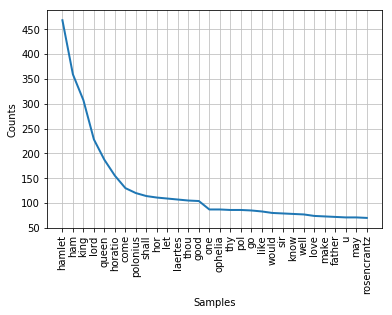

In [ ]:
# Term Frequency distribution to show the most used words
flat_list = [item for sublist in hamlet_processed for item in sublist]
# print(flat_list)
fdist = FreqDist(flat_list)
fdist.plot(30,cumulative=False)
plt.show()

The plot shows that the book is based in the character Hamlet (obviously), in a story of kings and lords (also obvious?). Next step in analysis is create a bag of words, obtaining 12.345 codified elements.



In [ ]:
# Bag of words
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1, 1), analyzer="word")
train_bow = bow.fit_transform(flat_list)
train_bow

<21428x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 36721 stored elements in Compressed Sparse Row format>

My next idea is to find the main characters of the film, and taking the previously defined contraction mapping, I create a list with them and count each dialogue for each character. Note that I take the book without being preprocessed, in order to counting extra nouns due to mapping contractions.

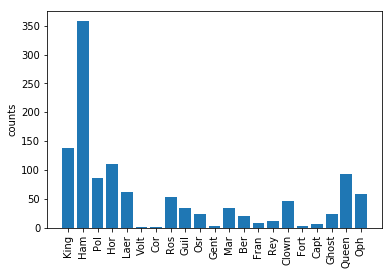

In [ ]:
# Discover the main character, counting the names of each main character
# First, insert the main characters
main_char = list(characters_contractions_mapping.keys())
flat_list1 = [item for sublist in hamlet for item in sublist]
hamlet_text = ''.join(map(str, flat_list1))

char_count = dict((x, 0) for x in main_char)
for w in re.findall(r"\w+", hamlet_text):
    if w in char_count:
        char_count[w] += 1
# print(wordcount)
plt.bar(range(len(char_count)), list(char_count.values()), align='center')
plt.xticks(range(len(char_count)), list(char_count.keys()), rotation=90)
plt.ylabel('counts')
plt.show()

I check in the plot that Hamlet is the main character of the book, followed by the King, Horatio, Polonius and the Queen. The next and final step is to create a Word2Vec, and find the most correlated words for one specific word.

In [ ]:
# Word2Vec
word2vec = Word2Vec(hamlet_processed, min_count=2)
vocabulary = word2vec.wv.vocab
vocabulary

{'act': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d1860>,
 'scene': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d1828>,
 'elsinore': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d1780>,
 'platform': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d1748>,
 'castle': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d1710>,
 'francisco': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d17b8>,
 'post': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d16d8>,
 'enter': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d3048>,
 'bernardo': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d3080>,
 'ber': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d30b8>,
 'fran': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d30f0>,
 'nay': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d3128>,
 'answer': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d3160>,
 'stand': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d3198>,
 'unfold': <gensim.models.keyedvectors.Vocab at 0x7f37ed1d31d0>,
 'long': <gensim.models.keyedvec

Finally, thanks to the previous Word2Vec, I can show the most correlated words. In this case, using "Hamlet" as input, we receive as output some interesting words as "father", or "leave".

In [ ]:
word = "hamlet"
sim_words = word2vec.wv.most_similar(word)
print("Most related words to: ", word)
for word in sim_words:
  print(word[0], word[1])

Most related words to:  hamlet
father 0.49798256158828735
good 0.4883986711502075
leave 0.47882941365242004
true 0.4716726243495941
hath 0.4690311551094055
night 0.46724462509155273
thy 0.46580755710601807
put 0.4642413258552551
call 0.46038955450057983
think 0.4580044150352478


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
